1. Split train and test
2. compute cross validation with
3. check confusion matrix
4. fit train and predict with test set
5. check results

## Data

In [2]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt

seeds = 1234
def set_seeds(seed=seeds):
    """Set seeds for reproducibility."""
    np.random.seed(seed)
    random.seed(seed)
# Set seeds
set_seeds()

### Load data

In [3]:
# load full training set
train = pd.read_pickle(r"train_enc.pkl")
test = pd.read_pickle(r"test_enc.pkl")

train.head()

,department,promoted,review,projects,salary,tenure,satisfaction,bonus,avg_hrs_month,left
4408,sales,0,0.853635,4,medium,5,0.259219,0,180.178543,1
5368,retail,0,0.661567,4,medium,6,0.311056,0,183.607849,0
4920,retail,0,0.591863,3,low,7,0.277298,0,185.288177,0
8402,engineering,0,0.659410,3,medium,7,0.698308,0,187.385620,1
5617,retail,0,0.653639,2,medium,6,0.219496,0,183.541580,0


### Split

In [4]:
# Separate labels and target from full training set
X_train, y_train =  train.drop(columns="left", axis = 1), train["left"]
# Separate labels and target from test set
X_test, y_test =  test.drop(columns="left", axis = 1), test["left"]


In [5]:
# Get variable names
bi_vars = [col for col in X_train.columns if X_train[col].nunique() == 2]
num_vars = [col for col in X_train.columns if (X_train[col].dtype in ["int8", "float32"]) & (col not in bi_vars)]
cat_vars = [col for col in X_train.columns if (col not in num_vars) & (col not in bi_vars)]

In [6]:
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import RepeatedStratifiedKFold

# Preprocessing recipe
preprocess = ColumnTransformer(
    transformers=[
        ("scaler", MinMaxScaler(), num_vars),
        ("ohe", OneHotEncoder(), cat_vars)
    ], remainder = "passthrough"
)

# K-folds
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=2, random_state=seeds)

Dummy | F2 score 0.673 +/- 0.001
LightGBM | F2 score 0.723 +/- 0.026
Catboost | F2 score 0.722 +/- 0.023
XGBoost | F2 score 0.720 +/- 0.023


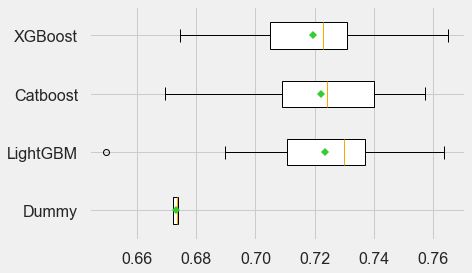

In [353]:
# Algorithm comparison

from sklearn.dummy import DummyClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import fbeta_score, make_scorer, precision_score, recall_score

##### Functions #########################
# generate f2 metric
def f2_measure(y_true, y_pred):
    return fbeta_score(y_true, y_pred, beta=2)

# Generate list for each clf
def get_clfs():
    clfs, names = list(), list()
    # DummyClassifier 
    clfs.append(DummyClassifier(strategy='constant', constant=1))
    names.append("Dummy")
    # LightGBM
    clfs.append(LGBMClassifier(random_state=seeds))
    names.append("LightGBM")
    # Catboost
    clfs.append(CatBoostClassifier(random_state=seeds))
    names.append("Catboost")
    # XGBoost 
    clfs.append(XGBClassifier(random_state=seeds))
    names.append("XGBoost")
    return clfs, names

# Cross validation
def evaluate_model(X, y, model):
    # Define the model evaluation metric
    metric = make_scorer(f2_measure)
    # Evaluate model
    scores = cross_val_score(model, X, y, scoring=metric, cv=cv, n_jobs=-1)
    return scores

###########################################################################


clfs, names = get_clfs()
results = list()
# Evaluate each model
for i in range(len(clfs)):
    # Wrap the model in a pipeline
    base_pipeline = make_pipeline(preprocess, clfs[i])
    # Evaluate the model and store results
    scores = evaluate_model(X_train, y_train, base_pipeline) # <-- using training set for CV
    results.append(scores)
    # Summarize and store
    print('%s | F2 score %.3f +/- %.3f' % (names[i], np.mean(scores), np.std(scores)))
    # Plot the results
plt.boxplot(results, labels=names, showmeans=True, vert=False, patch_artist=1,boxprops=dict(facecolor="white"),
            meanprops=dict(marker='D',markerfacecolor='limegreen',markersize=6),
            medianprops=dict(color="orange"))
#plt.style.use('fivethirtyeight')
plt.show()

In [377]:
base_pipeline

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('scaler', MinMaxScaler(),
                                                  ['review', 'projects',
                                                   'tenure', 'satisfaction',
                                                   'avg_hrs_month']),
                                                 ('ohe', OneHotEncoder(),
                                                  ['department', 'salary'])])),
                ('xgbclassifier',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_byt...
                               interaction_constraints=None, learning_rate=None,
                               max_delta_step=None, max_depth=None,
                               min_child_weight=None, missing=nan,
              

In [357]:
# Learning Curves
from sklearn.model_selection import learning_curve
train_sizes, train_scores, test_scores =  learning_curve(estimator=base_pipeline,
                               X=X_train,
                               y=y_train,
                               train_sizes=np.linspace(0.1, 1.0, 10),
                               cv=cv,
                               n_jobs=3)

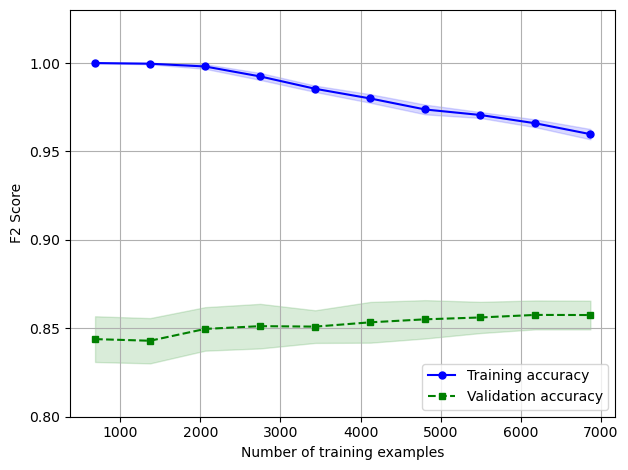

In [376]:
# Plot learning curves
plt.style.use('default')

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean,
         color='blue', marker='o',
         markersize=5, label='Training accuracy')

plt.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='Validation accuracy')

plt.fill_between(train_sizes,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')

plt.grid()
plt.xlabel('Number of training examples')
plt.ylabel('F2 Score')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.03])
plt.tight_layout()
plt.show()

## Cost senstive models

LightGBM | F2 score 0.789 +/- 0.024
Catboost | F2 score 0.784 +/- 0.019
XGBoost | F2 score 0.763 +/- 0.023


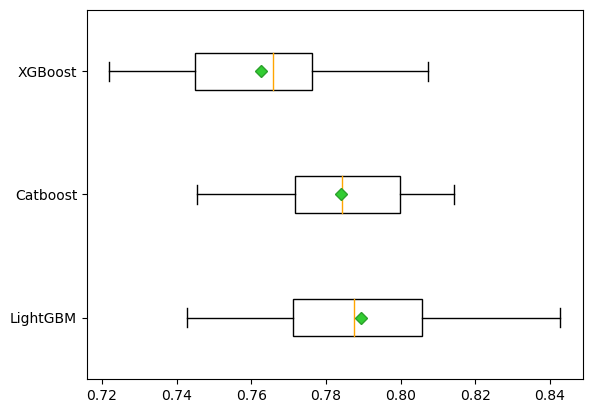

In [381]:
# Generate list for each clf
def get_clfs():
    clfs, names = list(), list()
    # LightGBM
    clfs.append(LGBMClassifier(random_state=seeds, scale_pos_weight=2))
    names.append("LightGBM")
    # Catboost
    clfs.append(CatBoostClassifier(random_state=seeds, scale_pos_weight=2))
    names.append("Catboost")
    # XGBoost 
    clfs.append(XGBClassifier(random_state=seeds, scale_pos_weight=2))
    names.append("XGBoost")
    return clfs, names

clfs, names = get_clfs()
results = list()
# Evaluate each model
for i in range(len(clfs)):
    # Wrap the model in a pipeline
    base_pipeline = make_pipeline(preprocess, clfs[i])
    # Evaluate the model and store results
    scores = evaluate_model(X_train, y_train, base_pipeline) # <-- using training set for CV
    results.append(scores)
    # Summarize and store
    print('%s | F2 score %.3f +/- %.3f' % (names[i], np.mean(scores), np.std(scores)))
    # Plot the results
plt.boxplot(results, labels=names, showmeans=True, vert=False, patch_artist=1,boxprops=dict(facecolor="white"),
            meanprops=dict(marker='D',markerfacecolor='limegreen',markersize=6),
            medianprops=dict(color="orange"))
plt.show()

TL | F2 score 0.758 +/- 0.026
ENN | F2 score 0.813 +/- 0.017
RENN | F2 score 0.815 +/- 0.014
SM | F2 score 0.784 +/- 0.022
BSM | F2 score 0.794 +/- 0.018
SVMSM | F2 score 0.778 +/- 0.026
SMTL | F2 score 0.788 +/- 0.023
SMTENN | F2 score 0.822 +/- 0.017


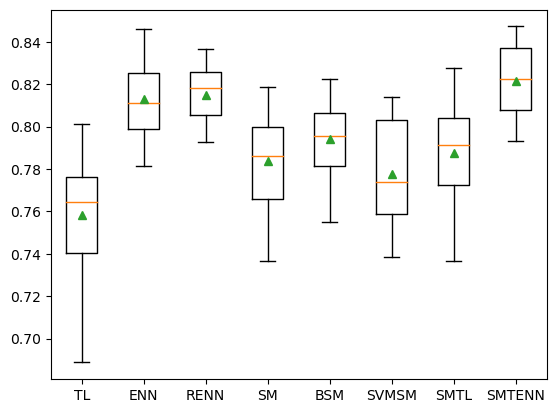

In [384]:
# Under
from imblearn.under_sampling import TomekLinks
from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.under_sampling import RepeatedEditedNearestNeighbours
# Over
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import SVMSMOTE
# Under + Over (smote)
from imblearn.combine import SMOTETomek 
from imblearn.under_sampling import TomekLinks
from imblearn.combine import SMOTEENN
from imblearn.pipeline import Pipeline

lgbm_model = LGBMClassifier(random_seed=seeds)

def get_sampling_methods():
    s_models, s_names = list(), list()
    # TL
    s_models.append(TomekLinks())
    s_names.append('TL')
    # ENN
    s_models.append(EditedNearestNeighbours())
    s_names.append('ENN')
    # RENN
    s_models.append(RepeatedEditedNearestNeighbours())
    s_names.append('RENN')
    # SM
    s_models.append(SMOTE())
    s_names.append('SM')
    # BSM
    s_models.append(BorderlineSMOTE())
    s_names.append('BSM')
    # SVMSM
    s_models.append(SVMSMOTE())
    s_names.append('SVMSM')
    # SMOTETomek
    s_models.append(SMOTETomek(tomek=TomekLinks(sampling_strategy='majority'),random_state=seeds))
    s_names.append('SMTL')
    # SMOTEENN
    s_models.append(SMOTEENN(enn=EditedNearestNeighbours(sampling_strategy='majority'),random_state=seeds))
    s_names.append('SMTENN')
    return s_models, s_names

# Define models
s_models, s_names = get_sampling_methods()
s_results = list()
# Evaluate each model
for i in range(len(s_models)):
    # Wrap the model in a pipeline
    s_pipeline = Pipeline(steps=[
        ('recipe', preprocess),
        ('s',s_models[i]),
        ("m", lgbm_model)
    ])
    # Evaluate the model and store results
    s_scores = evaluate_model(X_train, y_train, s_pipeline)
    s_results.append(s_scores)
    # Summarize and store
    print('%s | F2 score %.3f +/- %.3f' % (s_names[i], np.mean(s_scores), np.std(s_scores)))
# Plot the results
plt.boxplot(s_results, labels=s_names, showmeans=True, vert=False, patch_artist=1,boxprops=dict(facecolor="white"),
            meanprops=dict(marker='D',markerfacecolor='limegreen',markersize=6),
            medianprops=dict(color="orange"))
plt.show()

In [28]:
from imblearn.pipeline import make_pipeline, Pipeline

smoteen = SMOTEENN(enn=EditedNearestNeighbours(sampling_strategy='majority'),random_state=seeds)

lgbm_model = LGBMClassifier(random_seed=seeds)

pipe_lgbm = make_pipeline(preprocess, smoteen, lgbm_model)

In [26]:
lgbm_model.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': None,
 'random_state': None,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': 'warn',
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0,
 'random_seed': 1234}

In [23]:
import joblib
import lightgbm as lgb

from sklearn.compose import make_column_transformer
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder

from optuna.distributions import IntUniformDistribution, UniformDistribution
from optuna.integration import OptunaSearchCV


param_distributions = {
    'n_estimators': IntUniformDistribution(10, 100),
    'learning_rate': UniformDistribution(0.001, 0.1),

}

metric = make_scorer(f2_measure)

model_name = pipe_lgbm.steps[-1][0]
param_distributions = {model_name+'__'+key: value for key, value in param_distributions.items()}

In [24]:
optuna_search = OptunaSearchCV(pipe_lgbm, param_distributions, n_trials=50, n_jobs=-1, cv=cv, scoring=metric, random_state=seeds)

optuna_search.fit(X_train, y_train)

trained_model = optuna_search.best_estimator_

C:\Users\Eric\AppData\Local\Temp/ipykernel_22304/3788423351.py:1: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  optuna_search = OptunaSearchCV(pipe_lgbm, param_distributions, n_trials=50, n_jobs=-1, cv=cv, scoring=metric, random_state=seeds)
[I 2022-02-16 20:15:08,429] A new study created in memory with name: no-name-3842b64c-3303-4a7d-994a-ba3397d51241
C:\ProgramData\Anaconda3\envs\env_full\lib\site-packages\optuna\study\study.py:393: FutureWarning: `n_jobs` argument has been deprecated in v2.7.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.7.0.
  warnings.warn(
[I 2022-02-16 20:16:24,463] Trial 1 finished with value: 0.8208837050861792 and parameters: {'lgbmclassifier__n_estimators': 20, 'lgbmclassifier__learning_rate': 0.05812522467990001}. Best is trial 1 with value: 0.8208837050861792.
[I 2022-02-16 20:16:40,630] Trial 0 finished with value: 0.8057395982766135

In [25]:
trained_model

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('scaler', MinMaxScaler(),
                                                  ['review', 'projects',
                                                   'tenure', 'satisfaction',
                                                   'avg_hrs_month']),
                                                 ('ohe', OneHotEncoder(),
                                                  ['department', 'salary'])])),
                ('smoteenn',
                 SMOTEENN(enn=EditedNearestNeighbours(sampling_strategy='majority'),
                          random_state=1234)),
                ('lgbmclassifier',
                 LGBMClassifier(learning_rate=0.0811401792329023,
                                n_estimators=86, random_seed=1234))])

## EDA


## Preprocessing

## Modeling

#### Baseline

## Evaluation

In [47]:
clf = LGBMClassifier(
            n_estimators=10000,
            learning_rate=0.02,
            num_leaves=34,
            colsample_bytree=0.9497036,
            subsample=0.8715623,
            max_depth=8,
            reg_alpha=0.041545473,
            reg_lambda=0.0735294,
            min_split_gain=0.0222415,
            min_child_weight=39.3259775,
            silent=-1,
            verbose=-1)

In [48]:
model_lgbm = LGBMClassifier(boosting_type = 'goss', random_seed=seeds, class_weight = 'balanced', scale_pos_weight=2, learning_rate = 0.01, n_estimators = 1000,n_jobs = -1)

pipeline = make_pipeline(preprocess,smoteen, clf)

In [49]:
pipeline_eval = evaluate_model(X_train,y_train, pipeline)
print(' F2 score %.3f +/- %.3f' % (np.mean(pipeline_eval), np.std(pipeline_eval)))

 F2 score 0.813 +/- 0.016


In [50]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

pipeline.fit(X_train, y_train)
    # Obtain the predictions from our random forest model 
predicted = pipeline.predict(X_test)
    # Predict probabilities
probs = pipeline.predict_proba(X_test)
    # Print the ROC curve, classification report and confusion matrix
print(fbeta_score(y_test, predicted, beta=2))
print(classification_report(y_test, predicted))
print(confusion_matrix(y_test, predicted))

[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
0.8282307444408636
              precision    recall  f1-score   support

           0       0.96      0.73      0.83      1351
           1       0.59      0.92      0.72       557

    accuracy                           0.79      1908
   macro avg       0.77      0.83      0.77      1908
weighted avg       0.85      0.79      0.80      1908

[[990 361]
 [ 43 514]]
